In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import scipy.stats
# import imread

In [2]:
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

In [3]:
# MxN are Image dimensions 
# i and j is co-ordiantes of node being evaluated
# n is nearest neighbours


def neighbours(i,j,M,N,size=8):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        if (i==0 and j==0):
            n=[(0,1),(1,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2),(1,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1),(M-2,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2),(M-2,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j+1), (i+1,j-1)]
        return n
    return -1

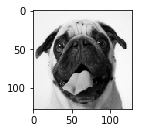

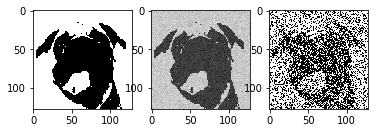

In [4]:
# proportion of pixels to alter

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def convertToBinary(im, threshold=0.5):
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if(im[i][j] >threshold):
                im[i][j] = 1
            else:
                im[i][j] = 0
    return im

prop = 0.7
prop2 = 0.3
varSigma = 0.1
im = rgb2gray(imread('pug128x128.png'))
# im = rgb2gray(imread.imread('pug128x128.png'))



im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im = convertToBinary(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im2 = add_gaussian_noise(im,prop,varSigma)
im2 = (im2 - im2.min())/(im2.max() - im2.min()) #normalising image
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')


im3 = add_saltnpeppar_noise(im,prop2)
im3 = (im3 - im3.min())/(im3.max() - im3.min())
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')

plt.show()

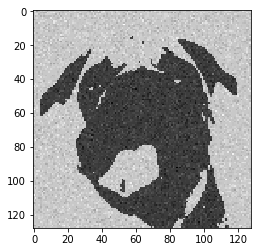

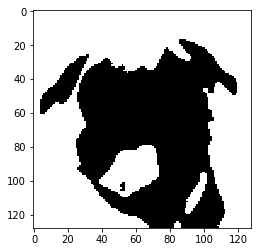

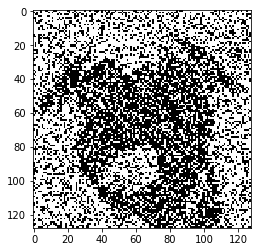

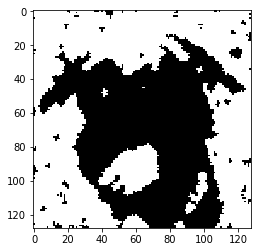

In [5]:
# Question 1 ICM
# Extra: extend noise (q1 extra)
# Iteratuve Conditional Modes
M, N = im2.shape

def prob(imX,originalIM,  i, j, beta, eta):
    n = neighbours(i,j, M,N, size=8)
    sumPlus = 0 
    sumMinus = 0
#     for k in range(np.shape(n)[0]):
#         sumPlus += imX[n[k]] * 1
#         sumMinus += imX[n[k]] * -1
    for k in range(np.shape(n)[0]):
        if imX[n[k]] >0.5:
            sumPlus += 1
        else:
            sumPlus -= 1 
    sumMinus = -sumPlus
    val1 = np.exp(-(- beta * sumPlus + eta*-((1*(2*originalIM[i][j] -1))+1)/2))
    val2 = np.exp(-(- beta * sumMinus + eta* -((-1*(2*originalIM[i][j] -1))+1)/2))
    return val1>val2

def denoise_ICM(imX, beta, eta, iterations):
    originalIM = imX.copy()
    x = imX.copy()
    for count in range(iterations):
        countChange = 0
        for i in  range(imX.shape[0]):
            for j in range(imX.shape[1]):
                if(prob(imX,originalIM, i,j,beta,eta)):
                    if(imX[i][j] != 1):
                        countChange += 1
                    x[i][j] = 1                  
                else:
                    if(imX[i][j] != -1):
                        countChange += 1
                    x[i][j] = -1
        if (countChange == 0): 
            print("Found minimum early: " + str(count))
            return x
        originalIM = imX.copy()
        imX = x.copy()
    return x


# imICM = denoise_ICM(im2, 0.5, 0.4, 0.7, 30)
im2ICM = denoise_ICM(im2, 0.5, 1, 10) # Imporoved performance
im3ICM = denoise_ICM(im3, 0.5, 1, 10)
# imICM = (imICM + 1)/2
fig = plt.figure()

plt.imshow(im2, cmap="gray")
plt.show()

plt.imshow(im2ICM, cmap="gray")
plt.show()

plt.imshow(im3, cmap="gray")
plt.show()

plt.imshow(im3ICM, cmap="gray")
plt.show()


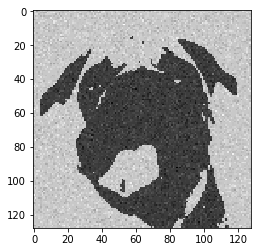

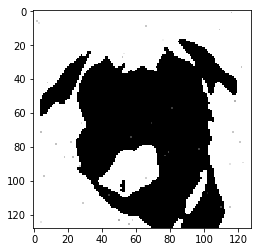

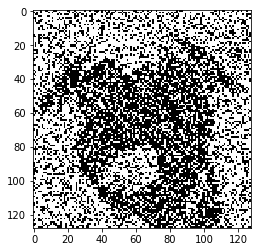

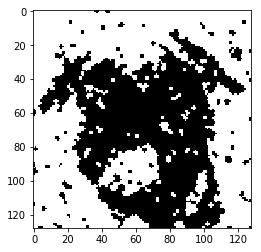

In [6]:
# Question 2 Gibbs Sampling
M, N = im2.shape

def prob_Gibbs(imXx, originalIM,  i, j, beta, eta):
    n = neighbours(i,j, M,N, size=8)
    sumPlus = 0 
    sumMinus = 0
    for k in range(np.shape(n)[0]):
        sumPlus += imXx[n[k]]*1
        sumMinus += imXx[n[k]]*-1
    prior_pos = np.exp((beta*sumPlus))
    prior_neg = np.exp((beta*sumMinus))
    likelihood_pos = np.exp(eta*((1*originalIM[i][j])+1)/2)
    likelihood_neg = np.exp(eta*((-1*originalIM[i][j])+1)/2)
#     likelihood_pos = scipy.stats.norm.pdf(originalIM[i][j],1,eta);
#     likelihood_neg = scipy.stats.norm.pdf(originalIM[i][j],-1,eta)
    outcome = (prior_pos*likelihood_pos)/(prior_pos*likelihood_pos + prior_neg*likelihood_neg)
#     outcome_neg = (val2)/(val1 + val2)
#     outcome = outcome_pos/(outcome_pos+outcome_neg)
    p = np.random.uniform(0,1);
    return outcome>p

def denoise_Gibbs(imX, beta, eta, iterations, random=False):
    originalIM = 2*imX.copy()-1
    x = 2*imX.copy()-1
    for count in range(iterations):
        if(random):
            for n in range(10000):
                i = np.random.randint(x.shape[0])
                j = np.random.randint(x.shape[1])
                if(prob_Gibbs(x,originalIM, i,j, beta, eta)):
                    x[i][j] = 1
                else:
                    x[i][j] = -1
        else:
            for i in  range(x.shape[0]):
                for j in range(x.shape[1]):
                    if(prob_Gibbs(x,originalIM,i,j, beta, eta)):
                        x[i][j] = 1
                    else:
                        x[i][j] = -1   
        originalIM = x.copy()
    return x


fig = plt.figure()
# imNormalised = 2*(im2.copy())-1
im2Gibbs = denoise_Gibbs(im2, 1.2, 10, 10, random=True)
im3Gibbs = denoise_Gibbs(im3, 1.2, 10, 10, random=False)


plt.imshow(im2,cmap='gray')
plt.show()

plt.imshow(im2Gibbs,cmap='gray')
plt.show()

plt.imshow(im3,cmap="gray")
plt.show()

plt.imshow(im3Gibbs, cmap="gray")
plt.show()

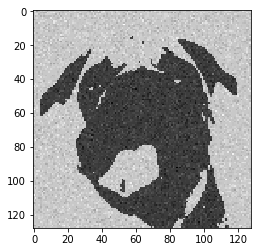

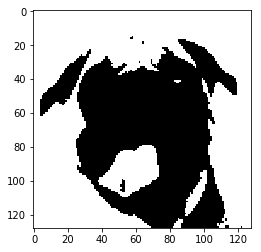

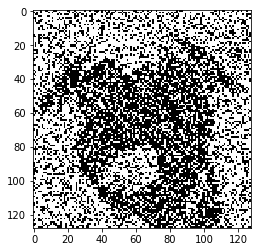

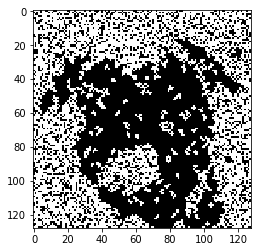

In [7]:
# Question 6 variational Bayes
M, N = im2.shape

def prob_vb(muCurrent, imX, originalIM, i, j, beta, eta):
    n = neighbours(i,j, M,N, size=8)
    m0 = 0 
    for k in range(np.shape(n)[0]):
        m0+= (muCurrent[n[k]])
    m0 = m0*beta
    posL = eta*((1*(2*originalIM[i][j] -1))+1)/2
    negL = eta*((-1*(2*originalIM[i][j] -1))+1)/2
    
    mu = np.tanh(m0 + 1/2*(posL - negL))
    return mu

def denoise_vb(imX, beta, eta, iterations):
    muCurrent = np.random.random_sample((M,N))
    muNext = muCurrent.copy()
    x = 2*imX.copy() -1
    originalIM = 2*imX.copy() -1
    for count in range(iterations):
        for i in  range(x.shape[0]):
            for j in range(x.shape[1]):
                muNext[i][j] = prob_vb(muCurrent, x, originalIM, i, j, beta, eta)
                if(muNext[i][j]>0):
                    x[i][j] = 1
                else:
                    x[i][j] = -1 
        originalIM = x.copy()
        muCurrent = muNext.copy()
    return x

fig = plt.figure()
# imNormalised = 2*(im2.copy())-1
im2Gibbs = denoise_vb(im2, 1.2, 10, 10)
im3Gibbs = denoise_vb(im3,  1.2, 10, 10)


plt.imshow(im2,cmap='gray')
plt.show()

plt.imshow(im2Gibbs,cmap='gray')
plt.show()

plt.imshow(im3,cmap="gray")
plt.show()

plt.imshow(im3Gibbs, cmap="gray")
plt.show()

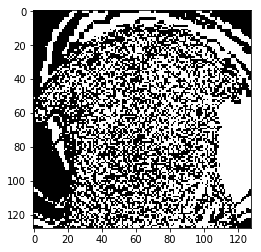

In [125]:
#Question 8 Image segmentation
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

M, N = im2.shape

def create_randomMasks(imX):
    foregroundMask = np.zeros((imX.shape[0],imX.shape[1]))
    for i in range (imX.shape[0]):
        for j in range (imX.shape[1]):
            random = np.random.randint(2)
            if(random == 1):
                foregroundMask[i][j] = 1
            else:
                foregroundMask[i][j] = -1
    return foregroundMask

def mask_2darray(imX, mask):
    result = []
    for i in range (imX.shape[0]):
        for j in range (imX.shape[1]):
            if(mask[i][j] == 1):
                result.append(imX[i][j])
                
    return np.array(result)

def calc_histogram(channel, maxRange):
    histogram = np.zeros(maxRange)
    for i in range (channel.size):
        histogram[int(channel[i])] +=1
    return histogram


def extract_colorChannel(imX, color=0):
    channel = np.zeros((imX.shape[0],imX.shape[1]))
    for i in range(imX.shape[0]):
        for j in range(imX.shape[1]):
            channel[i][j] = imX[i][j][color]
    return channel

def prob_histogram(imX, mask, histogramPos, histogramNeg, i, j, beta, eta, colorChannel=0):
    n = neighbours(i,j, M,N, size=8) 
    maskInv = (mask*-1)
    pos_sum = 0
    neg_sum = 0
    for k in range(np.shape(n)[0]):
        pos_sum += (mask[n[k]])*1
        neg_sum += (mask[n[k]])*-1
        
    
    prior_pos = np.exp((beta*pos_sum))
    prior_neg = np.exp((beta*pos_sum))
    likelihood_pos = np.exp(eta*histogramPos[imX[i][j][colorChannel]]/256)
    likelihood_neg = np.exp(eta*histogramNeg[imX[i][j][colorChannel]]/256)
    outcome = (prior_pos*likelihood_pos)/(prior_pos*likelihood_pos + prior_neg*likelihood_neg)
    val_pos = prior_pos*likelihood_pos
    val_neg = prior_neg*likelihood_neg 
#     p = np.random.uniform(0,1);
    return val_pos>val_neg

def getmaskedhistograms(foregroundMask, channelRed):
    backgroundMask = (foregroundMask*-1)
    channelRedmaskedF = mask_2darray(channelRed, foregroundMask)
    channelRedmaskedB = mask_2darray(channelRed, backgroundMask)
    histogramPos = calc_histogram(channelRedmaskedF, 256)
    histogramNeg = calc_histogram(channelRedmaskedB, 256)
    return histogramPos, histogramNeg

def segment_im(imX, beta, eta, iterations):
    foregroundMask = create_randomMasks(imX)
    channelRed = extract_colorChannel(imX)
    histogramPos, histogramNeg = getmaskedhistograms(foregroundMask,channelRed)
    
    for count in range(iterations):
        for i in  range(imX.shape[0]):
            for j in range(imX.shape[1]):
                if(prob_histogram(imX,foregroundMask, histogramPos, histogramNeg, i, j, beta, eta)):
                    foregroundMask[i][j] = 1
                else:
                    foregroundMask[i][j] = -1
        histogramPos, histogramNeg = getmaskedhistograms(foregroundMask, channelRed)
    return foregroundMask

imColor = imread('pug128x128.png')

mask = segment_im(imColor, 3, 10, 10)
index = (mask==1)
imColor[index] = [0, 0, 0]
plt.imshow(mask, cmap="gray")
plt.show()